In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from DomainPrediction.utils import helper

In [4]:
data_path = '../../../Data/al_test_experiments/Envision'

In [5]:
file = os.path.join(data_path, 'TEM1.csv')
df = pd.read_csv(file)

In [6]:
df.head()

,variant_id,id,reported_fitness,aa1,aa2,wt_mut,mut_type,position,Variant,scaled_effect1
0,beta-lactamase_P20P,TEM-1_P20P,0.581033,P,P,PP,synonymous,20,P20P,1.581033
1,beta-lactamase_D207D,TEM-1_D207D,0.425631,D,D,DD,synonymous,207,D207D,1.425631
2,beta-lactamase_A215A,TEM-1_A215A,0.422813,A,A,AA,synonymous,215,A215A,1.422813
3,beta-lactamase_C75C,TEM-1_C75C,0.415532,C,C,CC,synonymous,75,C75C,1.415532
4,beta-lactamase_N134N,TEM-1_N134N,0.396966,N,N,NN,synonymous,134,N134N,1.396966


In [7]:
wt = helper.read_fasta(os.path.join(data_path, 'TEM1_WT.fasta'), mode='str')[0]

In [8]:
df['mut_type'].unique()

array(['synonymous', 'missense'], dtype=object)

wt_mut column has nan values so don't use it

In [22]:
## sanity check againts wildtype for missense
for i, row in df[df['mut_type'] == 'missense'].iterrows():
    pos = row["position"]
    assert row["aa1"] == wt[pos-1]
    assert wt[pos-1] == row["Variant"][0]
    assert row["aa2"] == row["Variant"][-1]
    assert pos == int(row["Variant"][1:-1])

In [33]:
## sanity check againts wildtype for synonymous
mask = []
for i, row in df[df['mut_type'] == 'synonymous'].iterrows():
    pos = row["position"]
    assert row["aa1"] == row["aa2"] == row["Variant"][0] == row["Variant"][-1]
    assert pos == int(row["Variant"][1:-1])

    if pos >= len(wt):
        mask.append(False)
    else:
        mask.append(wt[pos-1] == row["aa1"])

mask = np.array(mask)

assert df[df['mut_type'] == 'synonymous'].shape[0] == mask.shape[0]

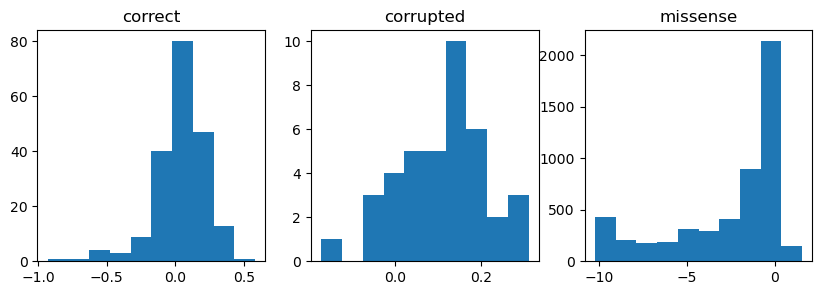

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(df[df['mut_type'] == 'synonymous'].iloc[mask]['reported_fitness'])
ax[1].hist(df[df['mut_type'] == 'synonymous'].iloc[~mask]['reported_fitness'])
ax[2].hist(df[df['mut_type'] == 'missense']['reported_fitness'])
ax[0].set_title('correct')
ax[1].set_title('corrupted')
ax[2].set_title('missense')
plt.show()

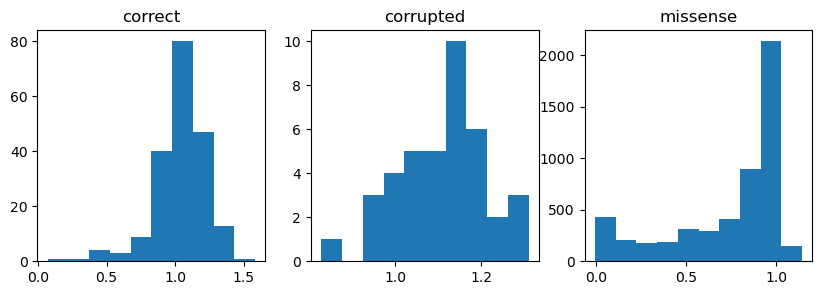

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))
ax[0].hist(df[df['mut_type'] == 'synonymous'].iloc[mask]['scaled_effect1'])
ax[1].hist(df[df['mut_type'] == 'synonymous'].iloc[~mask]['scaled_effect1'])
ax[2].hist(df[df['mut_type'] == 'missense']['scaled_effect1'])
ax[0].set_title('correct')
ax[1].set_title('corrupted')
ax[2].set_title('missense')
plt.show()

In [59]:
df.head()

,variant_id,id,reported_fitness,aa1,aa2,wt_mut,mut_type,position,Variant,scaled_effect1
0,beta-lactamase_P20P,TEM-1_P20P,0.581033,P,P,PP,synonymous,20,P20P,1.581033
1,beta-lactamase_D207D,TEM-1_D207D,0.425631,D,D,DD,synonymous,207,D207D,1.425631
2,beta-lactamase_A215A,TEM-1_A215A,0.422813,A,A,AA,synonymous,215,A215A,1.422813
3,beta-lactamase_C75C,TEM-1_C75C,0.415532,C,C,CC,synonymous,75,C75C,1.415532
4,beta-lactamase_N134N,TEM-1_N134N,0.396966,N,N,NN,synonymous,134,N134N,1.396966


In [71]:
df_new = df.loc[df['mut_type']=='missense', 
                ['position', 'Variant', 'reported_fitness', 'scaled_effect1']].copy()
df_new = df_new.reset_index(drop=True)
df_new.columns = ['pos', 'variant', 'fitness_raw', 'fitness_norm']

In [73]:
df_new.head()

,pos,variant,fitness_raw,fitness_norm
0,58,F58N,1.537240,1.142208
1,19,L19W,1.053720,1.094952
2,15,A15Y,0.823567,1.072459
3,182,A182M,0.768011,1.067029
4,281,S281F,0.768011,1.067029


In [74]:
df_new['wt_aa'] = df_new['variant'].apply(lambda x: x[0])
df_new['n_mut'] = 1

In [75]:
df_new.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut
0,58,F58N,1.537240,1.142208,F,1
1,19,L19W,1.053720,1.094952,L,1
2,15,A15Y,0.823567,1.072459,A,1
3,182,A182M,0.768011,1.067029,A,1
4,281,S281F,0.768011,1.067029,S,1


In [76]:
seqs = []
for i, row in df_new.iterrows():
    pos = row["pos"]
    assert wt[pos-1] == row["variant"][0]

    seq = wt[:pos-1] + row["variant"][-1] + wt[pos:]
    seqs.append(seq)

df_new['seq'] = seq

In [77]:
df_new.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut,seq
0,58,F58N,1.537240,1.142208,F,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1,19,L19W,1.053720,1.094952,L,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
2,15,A15Y,0.823567,1.072459,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
3,182,A182M,0.768011,1.067029,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4,281,S281F,0.768011,1.067029,S,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [78]:
## sanity check for n mutants
for i, row in df_new.iterrows():
    variant_seq = row["seq"]
    assert len(variant_seq) == len(wt)
    n = 0
    for a, b in zip(variant_seq, wt):
        if a != b:
            n += 1
    
    assert n == row['n_mut']

#### Data splits

In [80]:
df_new.shape

(5198, 7)

In [87]:
np.random.seed(0)

In [88]:
n_folds = 10
positions = np.sort(df_new['pos'].unique())
blocks = np.array_split(positions, n_folds)

assert sum(len(i) for i in blocks) == len(positions)

df_new['fold_id'] = -1
for i, _pos in enumerate(blocks):
    assert (df_new.loc[df_new['pos'].isin(_pos), 'fold_id'] == -1).all()
    df_new.loc[df_new['pos'].isin(_pos), 'fold_id'] = i

assert ~((df_new['fold_id'] == -1).any())

test_fold = [2, 6]
val_fold = [8]

df_new['split_id'] = -1
df_new.loc[df_new['fold_id'].isin(test_fold), 'split_id'] = 0
df_new.loc[df_new['fold_id'].isin(val_fold), 'split_id'] = 1
df_new.loc[~df_new['fold_id'].isin(test_fold+val_fold), 'split_id'] = 2

assert ~((df_new['split_id'] == -1).any())

In [89]:
df_new.head()

,pos,variant,fitness_raw,fitness_norm,wt_aa,n_mut,seq,fold_id,split_id
0,58,F58N,1.537240,1.142208,F,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,1,2
1,19,L19W,1.053720,1.094952,L,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2
2,15,A15Y,0.823567,1.072459,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,0,2
3,182,A182M,0.768011,1.067029,A,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,6,0
4,281,S281F,0.768011,1.067029,S,1,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,9,2


In [91]:
file = os.path.join(data_path, 'dataset_tem1.csv')
df_new.to_csv(file, index=False)

Text(0.5, 1.0, 'Test')

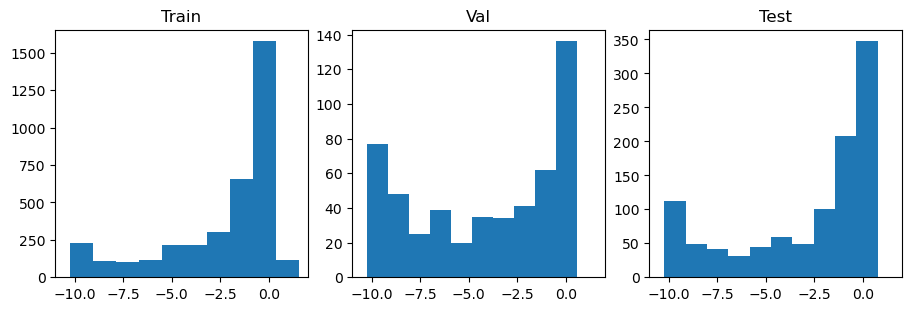

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_raw'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_raw'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_raw'])
ax[0].set_xlim(-11,2)
ax[1].set_xlim(-11,2)
ax[2].set_xlim(-11,2)
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')

Text(0.5, 1.0, 'Test')

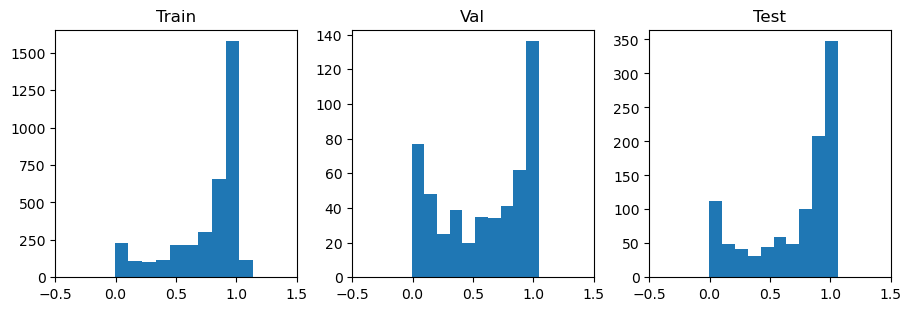

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_norm'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_norm'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_norm'])
ax[0].set_xlim(-0.5,1.5)
ax[1].set_xlim(-0.5,1.5)
ax[2].set_xlim(-0.5,1.5)
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')